# Assignment 5
# Part 1 - Read and elaborate

1.1 Read the paper [ShapeNet: An Information-Rich 3D Model Repository](https://arxiv.org/abs/1512.03012). What can you say about the importance and the challenges of building a large dataset for 3D machine learning?


Grande parte dos avanços dentro da área de aprendizado de máquina só foram possíveis graças a disponibilidade de dados, possibilitando as redes aprenderem distribuições com uma maior diversificação de dados. Além disso, ter as informações padronizadas em bases de dados é importante para que toda a comunidade tenha acesso ao mesmo conjunto, também facilitando comparações e avaliações no geral. Por fim, o fato de termos bases de dados cada vez mais ricas em diferentes aspectos também possibilita a geração de soluções para diferentes problemas, possibilitando avanços e aplicações para diferentes áreas.

Um dos desafios é como desenvolver uma estrutura que consiga organizar os dados de forma coerente, principalmente caso a base seja atualizada e expandida de tempos em tempos. Também é  necessário que estes dados sejam disponibilizados de maneira correta e diversificada. De acordo com o artigo, os próprios autores fazem ressalvas a respeito dos dados que foram categorizados, que possuem um bias pelo fato de terem utilizado modelos CAD. Nesse caso, a base de dados possue um número de objetos naturais menor devido ao tipo de modelo utilizado.

Pode-se perceber diversos desafios encontrados ao determinar uma base de dados vasta como ShapeNet. De acordo com os autores, o desafio principal para criar uma base de dados como ShapeNet é conseguir definir uma boa metodologia para adquirir e validar as anotações que são feitas em cada objeto. Seria muito custoso uma intervenção manual para realizar as anotações em cada objeto. Uma das formas utilizadas pelos criadores do ShapeNet foi aplicar algoritmos para gerar predições iniciais, e depois verificar essas predições através de uma votação por grupo de participantes, o que eles chamaram de estratégia híbrida. É fato que usar o trabalho manual é mais custoso do que usar algum algoritmo que faz uma predição, e tanto os algoritmos quanto humanos também podem estar sujeitos a erros. Para isso, cada anotação contém o modo em que foi avaliado, sendo uma forma de definir o quão confiável a informação é, e assim cada pessoa pode usar da forma que julgar mais conveniente.



# Part 2 - Learn

2.0 Run the following cells and read the explanations. It's an opportunity to get some familiarization with PyTorch3D. In "part 3" you are going to run some experiments.

In [36]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/s3d21')
#from myshapenetutils import render2meshplotly

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
!pip install torch torchvision
import os
import sys
import torch
if torch.__version__=='1.6.0+cu101' and sys.platform.startswith('linux'):
    !pip install pytorch3d
else:
    need_pytorch3d=False
    try:
        import pytorch3d
    except ModuleNotFoundError:
        need_pytorch3d=True
    if need_pytorch3d:
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

In [38]:
import numpy as np
import torch

from pytorch3d.datasets import (
    R2N2,
    ShapeNetCore,
    collate_batched_meshes,
    render_cubified_voxels,
)
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    RasterizationSettings,
    SoftPhongShader,
    TexturesVertex,
    TexturesUV,
    look_at_view_transform,
)

from pytorch3d.structures import Meshes
from torch.utils.data import DataLoader

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [39]:
import matplotlib.pyplot as plt

If using **Google Colab**, fetch the utils file for plotting image grids and the ShapeNet JSON files to map corresponding ids and categories:

In [40]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py

!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/pytorch3d/datasets/shapenet/shapenet_synset_dict_v1.json
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/pytorch3d/datasets/shapenet/shapenet_synset_dict_v2.json
!cp /content/shapenet_synset_dict_v1.json  /usr/local/lib/python3.7/dist-packages/pytorch3d/datasets/shapenet/shapenet_synset_dict_v1.json
!cp /content/shapenet_synset_dict_v2.json  /usr/local/lib/python3.7/dist-packages/pytorch3d/datasets/shapenet/shapenet_synset_dict_v2.json

from plot_image_grid import image_grid

--2021-06-05 00:14:19--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1472 (1.4K) [text/plain]
Saving to: ‘plot_image_grid.py.1’

plot_image_grid.py. 100%[===================>]   1.44K  --.-KB/s    in 0s      

2021-06-05 00:14:19 (28.5 MB/s) - ‘plot_image_grid.py.1’ saved [1472/1472]

--2021-06-05 00:14:20--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/pytorch3d/datasets/shapenet/shapenet_synset_dict_v1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connec

OR if running locally uncomment and run the following cell:

In [41]:
# from utils import image_grid

# 2.1. Load the datasets

We'll work on a small subset of the ShapeNetCore version 2 dataset. 

The whole dataset has more than 25GB and can be downloaded following the instructions here: https://www.shapenet.org/. Check the instructions page for the .zip file with our selected small subset of ShapeNet. If you are running on Google Colab, we suggest you upload the uncompressed folders to you Google Drive account and access its path here.

After downloading the data, modify `SHAPENET_PATH` below to you local path to the ShapeNetCore dataset folder. 

In [42]:
# Setup
if torch.cuda.is_available():
 device = torch.device("cuda:0")
 torch.cuda.set_device(device)
else:
 device = torch.device("cpu")

SHAPENET_PATH = "/content/drive/MyDrive/s3d21/SNCore.v2/"
shapenet_dataset = ShapeNetCore(SHAPENET_PATH,version=2)

/usr/local/lib/python3.7/dist-packages/pytorch3d/datasets/shapenet/shapenet_core.py:110: UserWarning:

The following categories are included in ShapeNetCore ver.2's official mapping but not found in the dataset location /content/drive/MyDrive/s3d21/SNCore.v2/: 03337140, 02773838, 02691156, 03001627, 03207941, 04256520, 03085013, 04090263, 02876657, 03261776, 02946921, 03636649, 03691459, 03642806, 04004475, 02818832, 03046257, 04460130, 03928116, 02843684, 04401088, 03991062, 04530566, 03797390, 02828884, 02871439, 02933112, 04330267, 03624134, 04468005, 03467517, 02747177, 02924116, 03593526, 02880940, 03211117, 04379243, 02958343, 02801938, 02808440, 03759954, 03790512, 03761084, 02942699, 04099429, 03325088, 04225987, 02954340, 03948459, 03938244, 02992529, 03513137



We can retrieve a model by indexing into the loaded dataset. We can examine the category this model belongs to (in the form of a synset id, equivalent to wnid described in ImageNet's API: http://image-net.org/download-API), its model id, and its vertices and faces.

In [43]:
print(device)
shapenet_model = shapenet_dataset[1]
print("This model belongs to the category " + shapenet_model["synset_id"] + ".")
print("This model has model id " + shapenet_model["model_id"] + ".")
model_verts, model_faces = shapenet_model["verts"], shapenet_model["faces"]

cuda:0
This model belongs to the category 03710193.
This model has model id 168b842e1b905547e5ffa6096479cd83.


/usr/local/lib/python3.7/dist-packages/pytorch3d/io/mtl_io.py:96: UserWarning:

Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.



We can use its vertices and faces to form a `Meshes` object which is a PyTorch3D datastructure for working with batched meshes.

In [44]:
model_textures = TexturesVertex(verts_features=torch.ones_like(model_verts, device=device)[None])
shapenet_model_mesh = Meshes(
    verts=[model_verts.to(device)],   
    faces=[model_faces.to(device)],
    textures=model_textures
)

## 2.2. Render ShapeNetCore models with PyTorch3D's differentiable renderer

The `ShapeNetCore` dataloader has a customized `render` function that support rendering models by specifying their model ids, categories or indices using PyTorch3D's differentiable renderer implementation.

In [45]:
# Rendering settings.
R, T = look_at_view_transform(1.0, 1.0, 90)
cameras = FoVPerspectiveCameras(R=R, T=T, device=device)
raster_settings = RasterizationSettings(image_size=512)
lights = PointLights(location=torch.tensor([0.0, 1.0, -2.0], device=device)[None],device=device)

First we will try to render three models by their model ids:

/usr/local/lib/python3.7/dist-packages/pytorch3d/io/mtl_io.py:96: UserWarning:

Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.



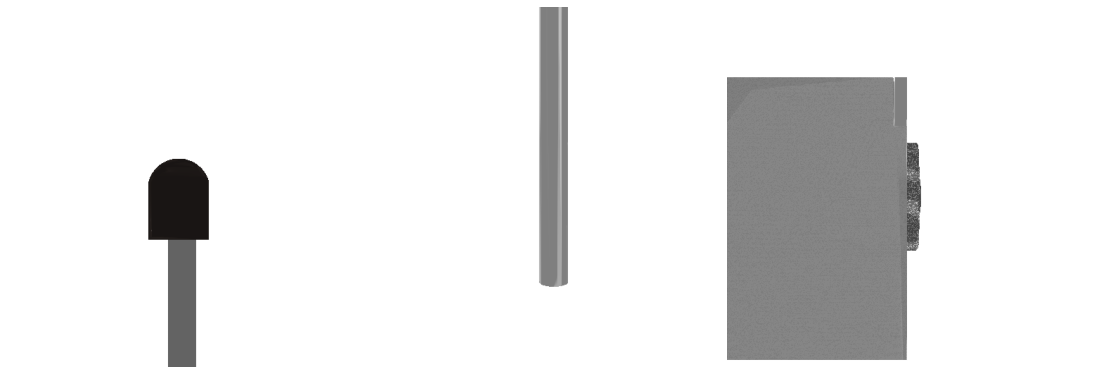

In [46]:
images_by_model_ids = shapenet_dataset.render(
    model_ids=[
        "1e4df43ee2f2da6967f9cc18b363cf72",
        "6f6ed9e0d29b64e714be24585075d395",
        "da0179a5b68f13586a6a687121d74e50"
    ],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_model_ids.cpu().numpy(), rows=1, cols=3, rgb=True)

We can also render models by their indices. For instance, if we would like to render the three models at indices 93, 109 and 200:

/usr/local/lib/python3.7/dist-packages/pytorch3d/io/mtl_io.py:96: UserWarning:

Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.



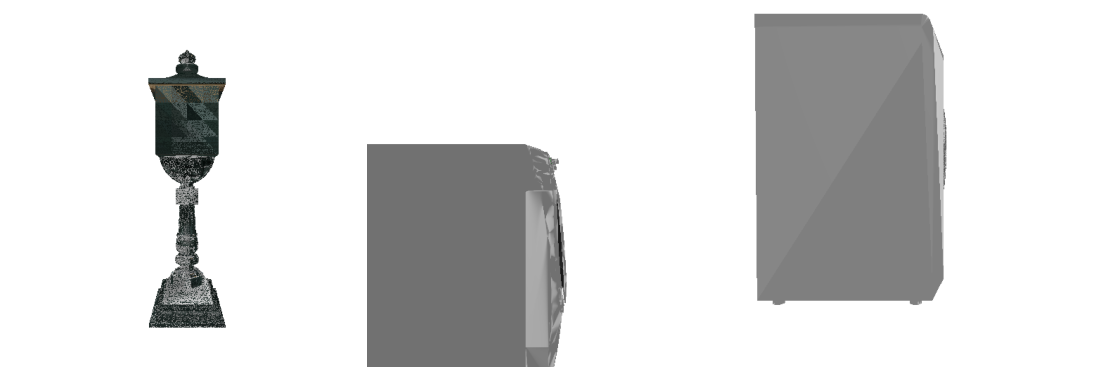

In [47]:
images_by_idxs = shapenet_dataset.render(
    idxs=[93, 109, 200],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_idxs.cpu().numpy(), rows=1, cols=3, rgb=True)

Alternatively, if we are not interested in any particular models but would like see random models from some specific categories, we can do that by specifying `categories` and `sample_nums`. For example, if we would like to render 2 models from the category "mailbox" and 3 models from the category "washer", we can do the following:

/usr/local/lib/python3.7/dist-packages/pytorch3d/io/mtl_io.py:96: UserWarning:

Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.



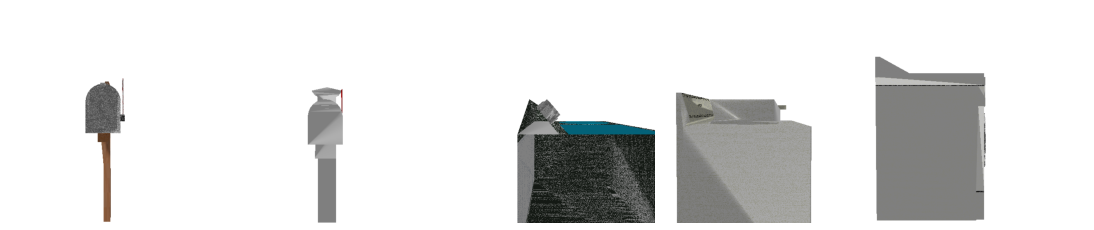

In [48]:
images_by_categories = shapenet_dataset.render(
    categories=["mailbox", "washer"], #we also have the category "remote" in this subset of ShapeNet
    sample_nums=[2, 3],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_categories.cpu().numpy(), rows=1, cols=5, rgb=True)

If we are not interested in any particular categories and just would like to render some random models from the whole dataset, we can set the number of models to be rendered in `sample_nums` and not specify any `categories`:

/usr/local/lib/python3.7/dist-packages/pytorch3d/io/mtl_io.py:96: UserWarning:

Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.



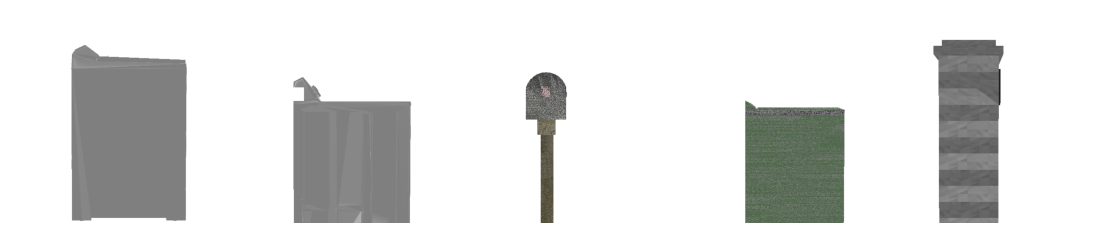

In [49]:
random_model_images = shapenet_dataset.render(
    sample_nums=[5],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(random_model_images.cpu().numpy(), rows=1, cols=5, rgb=True)

# Part 3 - Plotly Visualization

PyTorch3D has a differentiable renderer which allows us to generate images and take derivatives of the images with respect to the scene parameters. A differentiable renderer is very powerful, but it more computing intensive and it requires some setup. 

In this assignment, we only want to visualize the meshes, so we'll use Ploty for that. 

In [50]:
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

3.0. Show the number of instances in our subset of the ShapeNet dataset using the function `len` on `shapenet_dataset`

3.1. Create a Meshes object by taking it's vertices and faces from a shapenet model. Name your variable `myfirstmesh` so the code on the cell below display correctly.


In [51]:
print("Number of Instances:", len(shapenet_dataset))
#shapenet_dataset[0]['verts']
#shapenet_dataset[0]['faces']

Number of Instances: 329


In [52]:
myfirstmesh = Meshes(verts=[shapenet_dataset[300]['verts']], 
                     faces=[shapenet_dataset[300]['faces']]#, 
                    #textures=textures_vertex
                     )

In [53]:
# Render the plotly figure
from myshapenetutils import rendermeshplotly
rendermeshplotly(myfirstmesh)

As You just saw, the function `plot_scene` takes a dictionary of subplots and returns a plotly figure. Each subplot is a dictionary of kind `name: mesh`. 

3.2. You can render textured models using Ploty. Create a Meshes object passing `verts`, `faces` and `textures` arguments. `textures` must be a `TexturesVertex` object. It's not an easy task to create a `TextureVertex` directly from the ShapeNet model, so for now we suggest you create a simple tensor like a noisy color or other kind of pattern you can control. 

3.3. Create another Meshes object from ShapeNet and show both models in the same subplot. 
  
  **Extra - E.1: you can create a batch of Meshes instead of two or more individual Meshes objects. To do so, note that the arguments to build a Meshes instance are, in fact, lists.**


3.4. Each mesh is represented in its own coordinate system. This way, when you put them in the same subplot, they will overlap. This time, create a new subplot and plot the meshes. 

  **Extra - E.2: if you created a batch of Meshes, use the function** `plot_batch_individually`.


3.5. Experiment changing the figure size using `fig.update_layout(height:int,width:int)` . Experiment adding the arguments below to the `plot_scene` or `plot_batch_individually` functions.
```
  (...)
  xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
  yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
  zaxis={"backgroundcolor":"rgb(200, 230, 200)"},
  axis_args=AxisArgs(showgrid=True)
  (...)
  ```
  **Extra - E.3: Create a `Meshes` instance by computing vertices and faces of a parametric model and visualize it.**

In [54]:
#3.2
model_verts_1 = shapenet_dataset[300]['verts']
model_faces_1 = shapenet_dataset[300]['faces']
model_texdt_1 = torch.rand_like(model_verts_1*0.5 + 0.4)
model_textures_1 = TexturesVertex(verts_features=model_texdt_1[None].to(device))
print(dir(model_textures_1))
print(model_verts_1.shape)
tex_model_1 = Meshes(
    verts=[model_verts_1.to(device)],   
    faces=[model_faces_1.to(device)],
    textures=model_textures_1
)
from myshapenetutils import rendermeshplotly
rendermeshplotly(tex_model_1, "300")

['_N', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_extend', '_getitem', '_num_verts_per_mesh', '_verts_features_list', '_verts_features_padded', 'clone', 'detach', 'device', 'extend', 'faces_verts_textures_packed', 'isempty', 'join_batch', 'join_scene', 'sample_textures', 'to', 'valid', 'verts_features_list', 'verts_features_packed', 'verts_features_padded']
torch.Size([8013, 3])


In [71]:
#3.3
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.ops import sample_points_from_meshes

model_verts_2 = shapenet_dataset[290]['verts']
model_faces_2 = shapenet_dataset[290]['faces']

t1 = model_texdt_1
t2 = model_verts_2*0.5 + 0.4 

#torch.ones_like(model_verts_1, device=device),
model_textures = TexturesVertex([t1.to(device),
                                 t2.to(device)])
model_meshes = Meshes(
    verts=[model_verts_1.to(device), model_verts_2.to(device)],   
    faces=[model_faces_1.to(device), model_faces_2.to(device)],
    textures=model_textures)
 
# Render the plotly figure
fig = plot_scene({
    "300+290": {
        "shapenet_mesh1": model_meshes[0],
        "shapenet_mesh2": model_meshes[1]
    }
},
    xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
    yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
    zaxis={"backgroundcolor":"rgb(200, 230, 200)"},
    axis_args=AxisArgs(showgrid=True)
)
fig.show()

In [56]:
#Extra E.1 - list of data
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.ops import sample_points_from_meshes

model_verts_l = [shapenet_dataset[i+250]['verts'].to(device) for i in range(10)]
model_faces_l = [shapenet_dataset[i+250]['faces'].to(device) for i in range(10)]
model_textures_l_data = [#torch.tensor(model_verts_l[i]*0.5 + 0.4).to(device) for i in range(10)
                         torch.rand_like(model_verts_l[i]*0.5 + 0.4).to(device) for i in range(10)
                         #t[0:model_verts_l[i].shape[0]].to(device) for i in range(10)
                         #torch.ones_like(model_verts_l[i], device=device) for i in range(10)
                         ]
model_textures_l = TexturesVertex(verts_features=model_textures_l_data)

model_meshes_l_10 = Meshes(verts=model_verts_l,
                      faces=model_faces_l,
                      textures=model_textures_l)
 

/usr/local/lib/python3.7/dist-packages/pytorch3d/io/mtl_io.py:96: UserWarning:

Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.



In [72]:
#3.4
# Render the plotly figure
from myshapenetutils import render2meshplotly
render2meshplotly(model_meshes[0], model_meshes[1], "300", "290")

In [58]:
#Extra E.2
plot_batch_individually(model_meshes_l_10, ncols=5,
                          xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
  yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
  zaxis={"backgroundcolor":"rgb(200, 230, 200)"},
  axis_args=AxisArgs(showgrid=True))

Output hidden; open in https://colab.research.google.com to view.

In [59]:
#3.5
# Render the plotly figure
fig = plot_scene({
    "subplot1": {
        "shapenet_mesh": myfirstmesh
    }
  },
  xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
  yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
  zaxis={"backgroundcolor":"rgb(200, 230, 200)"},
  axis_args=AxisArgs(showgrid=True)
)
fig.show()

In [60]:
from PIL import Image

IMAGE_PATH = "/content/drive/MyDrive/s3d21/standardboard.png"
im = Image.open(IMAGE_PATH, 'r')
im_width, im_height = im.size
pixel_values = list(im.getdata())

# Output Images
im.show()
  
# prints format of image
print(im.format)
  
# prints mode of image
print(im.mode)
#np_c = np.array([c[0],c[1],c[2]], dtype = float)
#np_c = np_c / 255.0
#print(np_c)

PNG
RGBA


In [61]:
!pip install bezier==2020.1.14

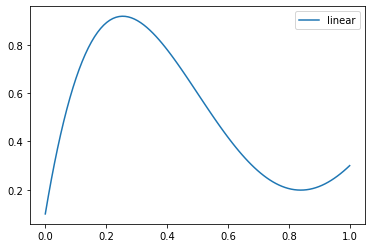

In [78]:
#Extra E.3
# https://pypi.org/project/bezier/

import math
import bezier
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

tex = np.zeros((im.height, im.width,3), dtype=float)
for i in range(im.width):
  for j in range(im.height):
    c = im.getpixel((i,j))
    tex[j,i] = [c[0] / 255.0, c[1] / 255.0, c[2] / 255.0]

image_uv_tex = torch.Tensor(tex)
#texture = TexturesUV(maps=t_tex, faces_uvs=faces, verts_uvs=verts_uv)

def d_create_vase_curve():
  v_nodes = np.asfortranarray([
     [0.0, 0.25,  0.5, 0.75, 1.0],
     [0.1, 2.0 ,  0.2, 0.0 , 0.3],
   ])
  return bezier.Curve.from_nodes(v_nodes)

def d_vase_function(z): # z [0,1]
  return d_create_vase_curve().evaluate(z)[1][0]
  #return 2 + math.cos(math.radians((z*1.2) * 360.0 - 180))

def d_vase_distance(u0, u1): # u0 u1 [0,1]
    fl = (d_vase_function(u1) -  d_vase_function(u0)) / (u1 - u0)
    #print(fl)
    return math.sqrt(1.0 + (fl*fl)) * (u1 - u0)

def d_vase_sample(z, theta): # z [0,1], theta[0,1]
    r = d_vase_function(z)
    angle = math.radians(theta * 360.0)
    return [r * math.sin(angle), z, r * math.cos(angle)]

def d_vase_accumulated_distance(x):
  d = 0
  for xi in np.arange(0.0, x, 0.01):
    x0 = xi
    x1 = xi + 0.01
    d = d + d_vase_distance(x0, x1)
  return d

def d_cilinder_function(z): # z [0,1]
    return 1.0

def d_cilinder_distance(u0, u1): # u0 u1 [0,1]
    fl = (d_cilinder_function(u1) -  d_cilinder_function(u0)) / (u1 - u0)
    return math.sqrt(1.0 + (fl*fl)) * (u1 - u0)

def d_cilinder_sample(z, theta): # z [0,1], theta[0,1]
    r = d_cilinder_function(z)
    angle = math.radians(theta * 360.0)
    return [r * math.sin(angle), z, r * math.cos(angle)]

def d_cilinder_accumulated_distance(x):
  d = 0
  for xi in np.arange(0.0, x, 0.01):
    x0 = xi
    x1 = xi + 0.01
    d = d + d_cilinder_distance(x0, x1)
  return d

def d_arc_function(z): # z [0,1]
    x = ((z-0.5)*2.0)
    return 1.0 - (x*x)

def d_arc_distance(u0, u1): # u0 u1 [0,1]
    fl = (d_arc_function(u1) -  d_arc_function(u0)) / (u1 - u0)
    return math.sqrt(1.0 + (fl*fl)) * (u1 - u0)

def d_arc_sample(z, theta): # z [0,1], theta[0,1]
    r = d_arc_function(z)
    angle = math.radians(theta * 360.0)
    return [r * math.sin(angle), z, r * math.cos(angle)]

def d_arc_accumulated_distance(x):
  d = 0
  for xi in np.arange(0.0, x, 0.01):
    x0 = xi
    x1 = xi + 0.01
    d = d + d_arc_distance(x0, x1)
  return d

def CreateRevolution2Mesh(n_profile_points, n_revolutions, f_accumulated_distance, f_sample, texuv):
  revolutions = n_revolutions
  z_points = n_profile_points

  pt_set = np.zeros((revolutions*z_points,3))
  faces = np.zeros((((z_points-1)*2)*revolutions, 3), dtype=int)
  tex_set = np.zeros((revolutions*z_points,3))
  tex_dist = np.zeros((revolutions*z_points,3))
  tex_uv_u = np.zeros((revolutions*z_points,2))
  tex_uv_d = np.zeros((revolutions*z_points,2))

  vase_total_distance = f_accumulated_distance(1.0)
  for rev_it in range(revolutions):
      j = rev_it * z_points
      for i in range(z_points):
        pt_set[j+i] = f_sample(i/float(z_points-1), rev_it/float(revolutions))
        pt_set[j+i][1] = (pt_set[j+i][1] - 0.5) * 2.0

        ft0 = i/float(z_points-1)
        ft1 = rev_it/float(revolutions-1)
        ftd = f_accumulated_distance(float(i)/float(z_points-1)) / vase_total_distance

        t0 = min(int(ft0 * im_width), im.width-1)
        t1 = min(int(ft1 * im_height), im.height-1)
        c = im.getpixel((t0,t1))
        np_c = np.array([c[0],c[1],c[2]], dtype = float)
        np_c = np_c / 255.0
        tex_set[j+i] = np_c

        td = min(int(ftd * im_width), im.width-1)
        cd = im.getpixel((td,t1))
        np_cd = np.array([cd[0],cd[1],cd[2]], dtype = float)
        np_cd = np_cd / 255.0
        tex_dist[j+i] = np_cd

        tex_uv_u[j+i] = [ft1, ft0]
        tex_uv_d[j+i] = [ft1, ftd]
       

  #print(np_c)

  face_id = 0
  for rev_it in range(revolutions):
      j0 = rev_it * z_points
      j1 = ((rev_it+1) % revolutions) * z_points
      for i in range(z_points-1):
          faces[face_id] = [int(j0+i), int(j1+i), int(j1+(i+1))]
          face_id = face_id + 1
          faces[face_id] = [int(j0+i), int(j1+(i+1)), int(j0+(i+1))]
          face_id = face_id + 1

  b_verts = torch.Tensor(pt_set)
  b_faces = torch.tensor(faces, dtype=int)

  b_t = torch.Tensor(tex_set) 
  b_d = torch.Tensor(tex_dist)
  b_uv_t = torch.Tensor(tex_uv_u) 
  b_uv_d = torch.Tensor(tex_uv_d)

  if texuv:
    b_textures = TexturesUV(maps=[image_uv_tex.to(device), image_uv_tex.to(device)],
                            faces_uvs=[b_faces.to(device), b_faces.to(device)],
                            verts_uvs=[b_uv_d.to(device), b_uv_t.to(device)])
  else:
    b_textures = TexturesVertex([b_d.to(device), b_t.to(device)])

  return Meshes(verts=[b_verts.to(device), b_verts.to(device)], 
                    faces=[b_faces.to(device), b_faces.to(device)],
                    textures = b_textures,
                  )      
  
def CreateCilinderMesh(n_profile_points, n_revolutions, texuv):
  return CreateRevolution2Mesh(n_profile_points, n_revolutions, d_cilinder_accumulated_distance, d_cilinder_sample, texuv)

def CreateVaseMesh(n_profile_points, n_revolutions, texuv):
  return CreateRevolution2Mesh(n_profile_points, n_revolutions, d_vase_accumulated_distance, d_vase_sample, texuv)

def CreateArcMesh(n_profile_points, n_revolutions, texuv):
  return CreateRevolution2Mesh(n_profile_points, n_revolutions, d_arc_accumulated_distance, d_arc_sample, texuv)


# Import the necessary packages and modules
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
#y[:] = d_cilinder_function(y[:])
#y[:] = d_arc_function(y[:])
for i in range(y.shape[0]):
  y[i] =  d_vase_function(y[i])

# Plot the data
plt.plot(x, y, label='linear')

# Add a legend
plt.legend()

# Show the plot
plt.show()  

In [63]:
beziermesh = CreateCilinderMesh(50,50, True)

In [79]:
beziermesh = CreateVaseMesh(50,50, True)

In [65]:
beziermesh = CreateArcMesh(50,50, True)

In [80]:
# Render the plotly figure
fig = plot_scene({
    "VaseMesh": {
        "shapenet_mesh": beziermesh[0]
    },
  },
      ncols=2,
  xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
  yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
  zaxis={"backgroundcolor":"rgb(200, 230, 200)"},
  axis_args=AxisArgs(showgrid=True)
)
fig.show()

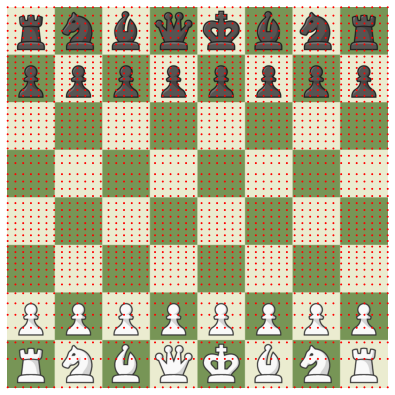

In [75]:
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
# PyTorch3D has a built-in way to view the texture map with matplotlib along with the points on the map corresponding to vertices.
plt.figure(figsize=(14,7))
texturesuv_image_matplotlib(beziermesh[0].textures, subsample=None)
plt.grid("off");
plt.axis("off");

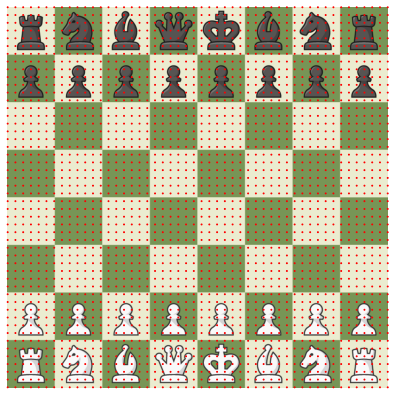

In [68]:
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
# PyTorch3D has a built-in way to view the texture map with matplotlib along with the points on the map corresponding to vertices.
plt.figure(figsize=(14,7))
texturesuv_image_matplotlib(beziermesh[1].textures, subsample=None)
plt.grid("off");
plt.axis("off");

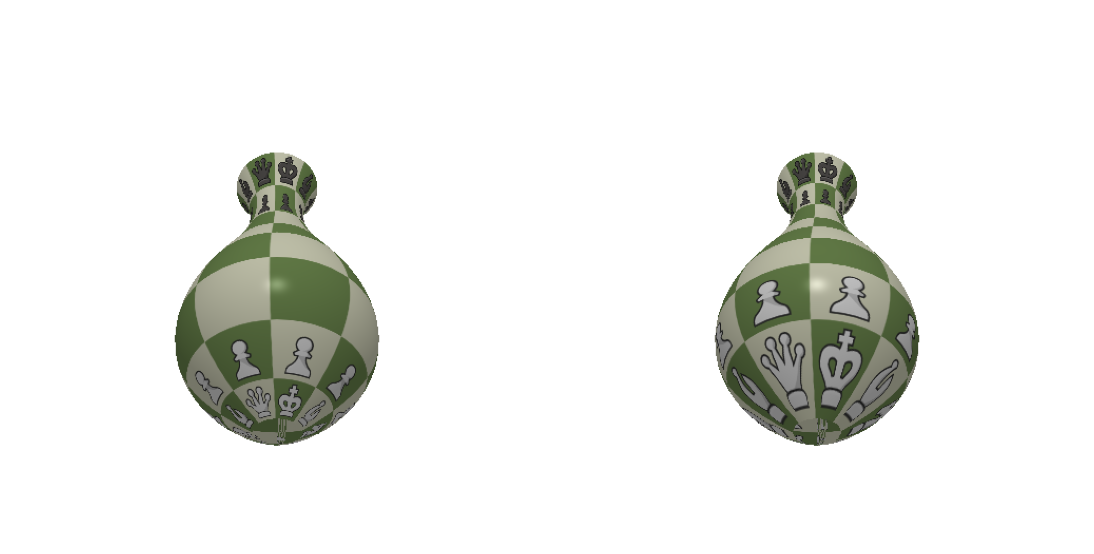

In [76]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, -50, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

images = renderer(beziermesh)
image_grid(images.cpu().numpy(), rows=1, cols=2, rgb=True)

In [81]:
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.structures import Meshes, join_meshes_as_batch, join_meshes_as_scene, Pointclouds
# the larger the face, the larger the probability of sampling point
points0, features0 = sample_points_from_meshes(beziermesh[0], num_samples=20000, return_textures=True)
points1, features1 = sample_points_from_meshes(beziermesh[1], num_samples=20000, return_textures=True)
pointcloud0 = Pointclouds(points=points0, features=features0)
pointcloud1 = Pointclouds(points=points1, features=features1)
# Render the plotly figure

from myshapenetutils import render2pointcloudplotly
render2pointcloudplotly(pointcloud0, pointcloud1, "Using distance function", "Using uniform distribution")

Output hidden; open in https://colab.research.google.com to view.